In [1]:
import os
import tensorflow as tf

# Set CUDA device order and visible devices
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8,9"

# Set the device
device = '/cpu:0'
if tf.config.experimental.list_physical_devices('GPU'):
    try:
        # Restrict TensorFlow to only use the second GPU
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            tf.config.experimental.set_visible_devices(gpus[7], 'GPU')
            device = '/gpu:7'
    except RuntimeError as e:
        print(e)

print("device", device)

2024-07-24 21:59:18.596259: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-24 21:59:18.614583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 21:59:18.630515: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 21:59:18.635340: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 21:59:18.651048: I tensorflow/core/platform/cpu_feature_guar

device /gpu:7


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
# from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import h5py

In [3]:
    
import h5py
import numpy as np

def load_data(file_path, num_images):
    images = []
    bounding_boxes = []
    centers = []

    with h5py.File(file_path, 'r') as h5file:
        for i in range(num_images):
            # Load image data
            image_dataset = f'image_{i}_image'
            image_data = np.array(h5file[image_dataset])
            images.append(image_data)

            # # Load bounding boxes
            # bbox_dataset = f'image_{i}_bounding_boxes_training'
            # bbox_data = np.array(h5file[bbox_dataset])
            # bounding_boxes.append(bbox_data)

            # Load center positions
            center_dataset = f'image_{i}_center_positions_training'
            center_data = np.array(h5file[center_dataset])
            centers.append(center_data)

    # Convert lists to NumPy arrays for easier handling in deep learning pipelines
    images = np.array(images)
    # bounding_boxes = np.array(bounding_boxes)
    centers = np.array(centers)

    return images, centers

# Example usage
file_path = '60000ImagesForTraining_negative paddings.h5'
num_images = 60000

images, centers = load_data(file_path, num_images)

# Verify shapes
print(f'Images shape: {images.shape}')
# print(f'Bounding boxes shape: {bounding_boxes.shape}')
print(f'Centers shape: {centers.shape}')


Images shape: (60000, 64, 64)
Centers shape: (60000, 12, 3)


In [3]:

# with h5py.File('//home/da886/ElectronCountingProject/TrainingData5zeroes midpoints.h5', 'r') as hdf:
#     ls = list(hdf.keys())
#     images = hdf.get('images')
#     # boxes = hdf.get('boxes')
#     center_coordinates = hdf.get('center_coordinates')
#     images = np.array(images)
#     # boxes = np.array(boxes)
#     center_coordinates = np.array(center_coordinates)

# image_normalized = (images + 1e-9) / 9.26

In [4]:
# Assuming images and centers are already defined
image_normalized = (images + 1e-9) / 9.26
center_coordinates = centers / [1, 64, 64]  # Normalizing the center coordinates
images_np = image_normalized
probabilities = np.array(center_coordinates[:, :, :-2])
probabilities =  tf.expand_dims(probabilities, axis=1)
center_coordinates_np = np.array(center_coordinates[:, :, 1:])
center_coordinates_np = tf.expand_dims(center_coordinates_np, axis=1)
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_midpoints_reshape': center_coordinates_np}))
# dataset = dataset.shuffle(buffer_size=10000,reshuffle_each_iteration= True).batch(batch_size)
# # Determine the size of the dataset
dataset_size = len(images_np)

# Calculate the number of samples for training (e.g., 80% for training, 20% for validation)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Shuffle each dataset separately
train_dataset = train_dataset.shuffle(buffer_size=512,reshuffle_each_iteration= True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=512,reshuffle_each_iteration= True).batch(batch_size)

# Prefetch to improve performance
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)


2024-07-24 22:00:10.497286: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 7, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c9:00.0, compute capability: 8.0


In [5]:
center_coordinates_np[9]

<tf.Tensor: shape=(1, 12, 2), dtype=float64, numpy=
array([[[ 0.5546875,  0.2578125],
        [-0.015625 , -0.015625 ],
        [-0.015625 , -0.015625 ],
        [-0.015625 , -0.015625 ],
        [-0.015625 , -0.015625 ],
        [-0.015625 , -0.015625 ],
        [-0.015625 , -0.015625 ],
        [-0.015625 , -0.015625 ],
        [-0.015625 , -0.015625 ],
        [-0.015625 , -0.015625 ],
        [-0.015625 , -0.015625 ],
        [-0.015625 , -0.015625 ]]])>

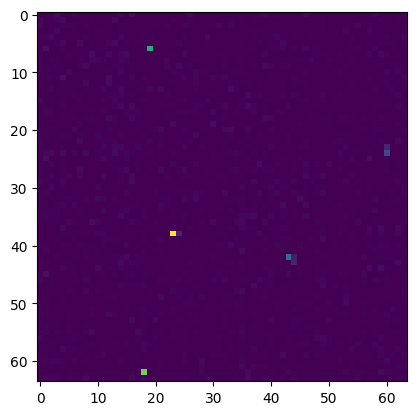

In [6]:
plt.imshow(images_np[1])

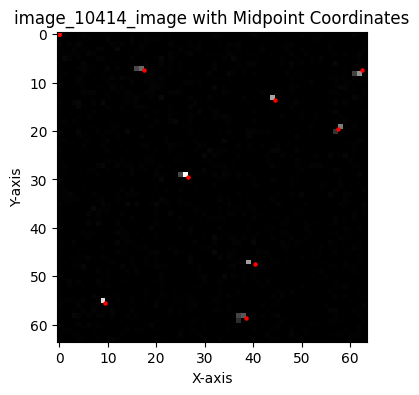

In [10]:
# # File path to the HDF5 file
# file_path = '/home/da886/ElectronCountingProject/60KImages_64x64Training10electronhits.h5'

# # Function to visualize the first image with midpoint coordinates
# def visualize_first_image_with_midpoints(file_path):
#     # Open the HDF5 file
#     h5_file = h5py.File(file_path, 'r')

#     # Get the list of image keys and midpoint keys
#     image_keys = [key for key in h5_file.keys() if 'image' in key and '_image' in key]
#     midpoint_keys = [key for key in h5_file.keys() if 'center_positions' in key and '_center_positions' in key]

#     d = np.random.randint(0, 10000)
#     # Select the first key for visualization
#     selected_image_key = image_keys[d]
#     selected_midpoint_key = selected_image_key.replace('_image', '_center_positions')

#     # Extract the image and midpoint coordinates
#     image_data = h5_file[selected_image_key][:]
#     midpoints = h5_file[selected_midpoint_key][:]
    
#     # Close the file
#     h5_file.close()

#     # Plot the first image with midpoint coordinates
#     plt.figure(figsize=(4, 5))
#     plt.imshow(image_data, cmap='gray')
#     plt.scatter(midpoints[:, 0], midpoints[:, 1], c='red', s=5)
#     plt.title(f'{selected_image_key} with Midpoint Coordinates')
#     plt.xlabel('X-axis')
#     plt.ylabel('Y-axis')
#     plt.show()

# # Call the function with the file path
# visualize_first_image_with_midpoints(file_path)

In [6]:
np.max(image_normalized)

903.7796976242981

(array([[64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [62.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [64.,  0.,  0.,  0.,  0.,  0.,  

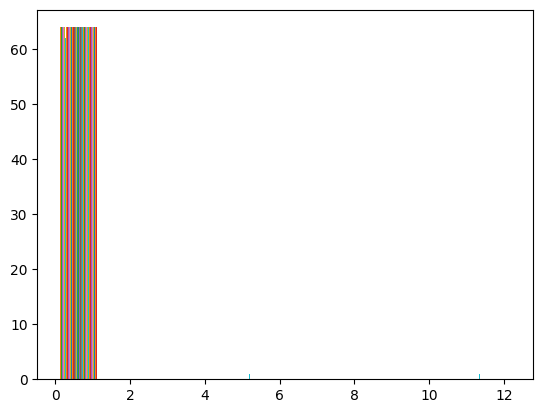

In [6]:
# p = np.random.randint(0,len(center_coordinates_np))
# center_coordinates_np[p]
plt.hist(image_normalized[0].squeeze())

Josh's suggestion

In [5]:
# input_shape = (64, 64, 1)
# num_classes = 12
# num_coordinates = 2


# x_input = layers.Input(shape=input_shape)
# #Layer 1
# x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x_input)
# x = layers.MaxPool2D()(x)
# x = layers.BatchNormalization()(x) 
# x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)

# # #Layer 2
# # x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
# # x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)

# # #Layer 3
# # x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
# # x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)

# # #Layer 4
# # x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
# # x = layers.MaxPool2D()(x)
# # x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
# # x = layers.MaxPool2D()(x)
# # x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
# # x = layers.MaxPool2D()(x)

# #Layer 5
# x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
# x = layers.MaxPool2D()(x)
# x = layers.BatchNormalization()(x) 


# x = layers.Flatten()(x)
# # Probability output
# x_prob = layers.Dense(num_classes, activation='sigmoid', name='x_prob')(x)
# x_prob_reshape = layers.Reshape((-1,num_classes,1), name='x_prob_reshape')(x_prob)

# # Bounding box output
# x_midpoints = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_midpoints')(x)
# x_midpoints_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_midpoints_reshape')(x_midpoints)




# model = tf.keras.models.Model(x_input, [x_prob_reshape,x_midpoints_reshape])
# optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) 


In [7]:
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

input_shape = (64, 64, 1)
num_classes = 12
num_coordinates = 2


x_input = layers.Input(shape=input_shape)
#Layer 1
x = layers.Conv2D(1025, kernel_size=3, padding='same', activation='relu')(x_input)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, kernel_size=5, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 
x = layers.Dropout(0.3)(x) 


x = layers.Flatten()(x)

x = layers.Dense(128,activation='relu')(x)
# Probability output
x_prob = layers.Dense(num_classes, activation='sigmoid', name='x_prob')(x)
x_prob_reshape = layers.Reshape((-1,num_classes,1), name='x_prob_reshape')(x_prob)

# Bounding box output
x_midpoints = layers.Dense(num_classes * num_coordinates, activation='linear', name='x_midpoints')(x)
x_midpoints_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_midpoints_reshape')(x_midpoints)




model = tf.keras.models.Model(x_input, [x_prob_reshape,x_midpoints_reshape])
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) 



In [8]:
@tf.keras.utils.register_keras_serializable()
class MaskedMeanSquaredError(tf.keras.losses.Loss):
    def __init__(self, name="masked_mse_loss", **kwargs):
        super().__init__(name=name, **kwargs)

    def call(self, y_true, y_pred):
        # Create mask
        mask = tf.reduce_sum(y_true, axis=-1) > -1
        mask = tf.cast(mask, tf.float32)
        mask = tf.expand_dims(mask, axis=-1)

        # Apply mask to the true and predicted values
        y_true_masked = y_true * mask
        y_pred_masked = y_pred * mask

        # Calculate mean squared error
        mse = tf.reduce_mean(tf.square(y_true_masked - y_pred_masked), axis=-1)
        # mse = tf.keras.losses.MeanSquaredError(y_true_masked,y_pred_masked)
        # Normalize the loss by the number of non-zero elements in the mask
        mask_sum = tf.reduce_sum(mask)
        masked_loss = tf.reduce_sum(mse) / mask_sum
        return masked_loss


@tf.keras.utils.register_keras_serializable()
class MaskedBinaryCrossentropy(tf.keras.losses.Loss):
    def __init__(self, name="masked_binary_crossentropy", **kwargs):
        super().__init__(name=name, **kwargs)

    def call(self, y_true, y_pred):
        # Create mask
        mask = tf.reduce_sum(y_true, axis=-1) > 0
        mask = tf.cast(mask, tf.float32)
        mask = tf.expand_dims(mask, axis=-1)

        # Apply mask to the true and predicted values
        y_true_masked = y_true * mask
        y_pred_masked = y_pred * mask

        # Calculate binary cross-entropy
        bce = tf.keras.losses.binary_crossentropy(y_true_masked, y_pred_masked)

        # Normalize the loss by the number of non-zero elements in the mask
        mask_sum = tf.reduce_sum(mask)
        masked_loss = tf.reduce_sum(bce) / mask_sum
        return masked_loss


In [9]:

model.compile(optimizer= optimizer, loss= {'x_prob_reshape': MaskedBinaryCrossentropy(), 'x_midpoints_reshape':MaskedMeanSquaredError()})   


In [10]:
model = tf.keras.models.load_model("/home/da886/ElectronCountingProject/Weights from my data/weights for negative paddings/denseadded3rd train.h5") ####the weights are for 60000images. it was a typo

/home/da886/anaconda3/envs/objectdetection/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
from tensorflow.keras import layers, callbacks
# Custom callback to save the model every 10 epochs
class CustomModelCheckpoint(callbacks.Callback):
    def __init__(self, save_freq, save_path):
        super(CustomModelCheckpoint, self).__init__()
        self.save_freq = save_freq
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(self.save_path.format(epoch=epoch + 1))
            print(f"Model saved at epoch {epoch + 1}")

save_freq = 20  # Save every 10 epochs
save_path = "/home/da886/ElectronCountingProject/Weights from my data/weights for negative paddings/denseadded2nd_epoch_{epoch:02d}.h5"
checkpoint_callback = CustomModelCheckpoint(save_freq=save_freq, save_path=save_path)

In [12]:
model.fit(train_dataset,epochs=130,validation_data=val_dataset,callbacks =[checkpoint_callback])

Epoch 1/130


I0000 00:00:1721858527.753046 1680051 service.cc:146] XLA service 0x7f405c01b780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721858527.753383 1680051 service.cc:154]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-07-24 22:02:07.782572: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-24 22:02:08.084101: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-07-24 22:02:08.366271: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility pa

  1/375 ━━━━━━━━━━━━━━━━━━━━ 4:59:43 48s/step - loss: 0.0301

I0000 00:00:1721858574.132044 1680051 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 118s 187ms/step - loss: 0.0887 - val_loss: 0.1341
Epoch 2/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 78s 140ms/step - loss: 0.0405 - val_loss: 0.0665
Epoch 3/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 144ms/step - loss: 0.0358 - val_loss: 0.0766
Epoch 4/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 143ms/step - loss: 0.0323 - val_loss: 0.0739
Epoch 5/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 141ms/step - loss: 0.0296 - val_loss: 0.1015
Epoch 6/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 142ms/step - loss: 0.0275 - val_loss: 0.1260
Epoch 7/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0259 - val_loss: 0.0956
Epoch 8/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 148ms/step - loss: 0.0245 - val_loss: 0.0656
Epoch 9/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0233 - val_loss: 0.0648
Epoch 10/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 142ms/step - loss: 0.0221 - val_loss: 0.0644
Epoch 11/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 141ms/step - loss: 0.0213 - val_loss: 0.0992
Epoch 12/130
375/37

Model saved at epoch 20
375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 142ms/step - loss: 0.0164 - val_loss: 0.0974
Epoch 21/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0160 - val_loss: 0.0735
Epoch 22/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 148ms/step - loss: 0.0156 - val_loss: 0.0654
Epoch 23/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 141ms/step - loss: 0.0153 - val_loss: 0.0937
Epoch 24/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 141ms/step - loss: 0.0150 - val_loss: 0.0833
Epoch 25/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 148ms/step - loss: 0.0148 - val_loss: 0.0801
Epoch 26/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 148ms/step - loss: 0.0145 - val_loss: 0.0807
Epoch 27/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 142ms/step - loss: 0.0141 - val_loss: 0.0662
Epoch 28/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 142ms/step - loss: 0.0141 - val_loss: 0.0729
Epoch 29/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 147ms/step - loss: 0.0138 - val_loss: 0.0717
Epoch 30/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 148ms/step - loss: 0.0136 - val_l

Model saved at epoch 40
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 145ms/step - loss: 0.0120 - val_loss: 0.0746
Epoch 41/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 142ms/step - loss: 0.0119 - val_loss: 0.0812
Epoch 42/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 145ms/step - loss: 0.0118 - val_loss: 0.0706
Epoch 43/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 80s 139ms/step - loss: 0.0116 - val_loss: 0.0641
Epoch 44/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 140ms/step - loss: 0.0115 - val_loss: 0.0841
Epoch 45/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 140ms/step - loss: 0.0113 - val_loss: 0.0616
Epoch 46/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 140ms/step - loss: 0.0112 - val_loss: 0.0619
Epoch 47/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 142ms/step - loss: 0.0111 - val_loss: 0.0627
Epoch 48/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - loss: 0.0110 - val_loss: 0.0647
Epoch 49/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 147ms/step - loss: 0.0109 - val_loss: 0.0646
Epoch 50/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 149ms/step - loss: 0.0108 - val_l

Model saved at epoch 60
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0099 - val_loss: 0.0635
Epoch 61/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 141ms/step - loss: 0.0098 - val_loss: 0.0643
Epoch 62/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 141ms/step - loss: 0.0099 - val_loss: 0.0619
Epoch 63/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0098 - val_loss: 0.1099
Epoch 64/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 141ms/step - loss: 0.0096 - val_loss: 0.0637
Epoch 65/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - loss: 0.0095 - val_loss: 0.0647
Epoch 66/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 145ms/step - loss: 0.0096 - val_loss: 0.0742
Epoch 67/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 152ms/step - loss: 0.0095 - val_loss: 0.0629
Epoch 68/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 78s 141ms/step - loss: 0.0094 - val_loss: 0.0640
Epoch 69/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 145ms/step - loss: 0.0093 - val_loss: 0.0666
Epoch 70/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 144ms/step - loss: 0.0093 - val_l

Model saved at epoch 80
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 149ms/step - loss: 0.0087 - val_loss: 0.0614
Epoch 81/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 64s 170ms/step - loss: 0.0087 - val_loss: 0.0762
Epoch 82/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 184ms/step - loss: 0.0086 - val_loss: 0.0632
Epoch 83/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 183ms/step - loss: 0.0085 - val_loss: 0.0661
Epoch 84/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 183ms/step - loss: 0.0085 - val_loss: 0.0637
Epoch 85/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 181ms/step - loss: 0.0085 - val_loss: 0.0648
Epoch 86/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 181ms/step - loss: 0.0084 - val_loss: 0.0602
Epoch 87/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 183ms/step - loss: 0.0084 - val_loss: 0.0649
Epoch 88/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 72s 191ms/step - loss: 0.0084 - val_loss: 0.0763
Epoch 89/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 78s 180ms/step - loss: 0.0084 - val_loss: 0.0670
Epoch 90/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 178ms/step - loss: 0.0083 - val_l

Model saved at epoch 100
375/375 ━━━━━━━━━━━━━━━━━━━━ 75s 198ms/step - loss: 0.0079 - val_loss: 0.0651
Epoch 101/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 180ms/step - loss: 0.0079 - val_loss: 0.0629
Epoch 102/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 181ms/step - loss: 0.0078 - val_loss: 0.0616
Epoch 103/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 179ms/step - loss: 0.0077 - val_loss: 0.0637
Epoch 104/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 179ms/step - loss: 0.0078 - val_loss: 0.0629
Epoch 105/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 178ms/step - loss: 0.0077 - val_loss: 0.0626
Epoch 106/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 187ms/step - loss: 0.0077 - val_loss: 0.0599
Epoch 107/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 73s 193ms/step - loss: 0.0076 - val_loss: 0.0677
Epoch 108/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 72s 191ms/step - loss: 0.0076 - val_loss: 0.0607
Epoch 109/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 72s 190ms/step - loss: 0.0075 - val_loss: 0.0633
Epoch 110/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 191ms/step - loss: 0.0

Model saved at epoch 120
375/375 ━━━━━━━━━━━━━━━━━━━━ 75s 198ms/step - loss: 0.0072 - val_loss: 0.0633
Epoch 121/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 182ms/step - loss: 0.0073 - val_loss: 0.0630
Epoch 122/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 189ms/step - loss: 0.0072 - val_loss: 0.0610
Epoch 123/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 178ms/step - loss: 0.0071 - val_loss: 0.0620
Epoch 124/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 177ms/step - loss: 0.0071 - val_loss: 0.0628
Epoch 125/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 179ms/step - loss: 0.0070 - val_loss: 0.0616
Epoch 126/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 182ms/step - loss: 0.0070 - val_loss: 0.0613
Epoch 127/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 179ms/step - loss: 0.0070 - val_loss: 0.0619
Epoch 128/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 180ms/step - loss: 0.0070 - val_loss: 0.0604
Epoch 129/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 181ms/step - loss: 0.0070 - val_loss: 0.0665
Epoch 130/130
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 180ms/step - loss: 0.0

In [17]:

model.save("/home/da886/ElectronCountingProject/Weights from my data/weights for negative paddings/denseadded2nd train.h5")
# model.save("/home/da886/ElectronCountingProject/Weights from my data/weights for negative paddings/2nd train.h5")    ###save next as 3rd train
# model = tf.keras.models.load_model("/home/da886/ElectronCountingProject/Weights from my data/weights for negative paddings/1st train.keras")###
# model = tf.keras.models.load_model("/home/da886/ElectronCountingProject/Weights from my data/weights for negative paddings/2nd train.keras")

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_midpoints_reshape': center_coordinates_np}))
dataset = dataset.batch(500)

inputs,targets = next(iter(dataset))
# inputs,targets = next(iter(test_dataset))
output =model.predict(inputs)

16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step


In [14]:
import tensorflow as tf

# r = np.random.randint(0,100)
tensor1 = tf.constant(targets['x_midpoints_reshape'], dtype=tf.float64)

tensor2 = tf.constant(output[1], dtype=tf.float32)


tensor2 = tf.cast(tensor2, tf.float64)


mse_loss_fn = MaskedMeanSquaredError()
mse_loss = mse_loss_fn(tensor1, tensor2)

print("MSE Loss:", mse_loss.numpy())

MSE Loss: 0.009427163


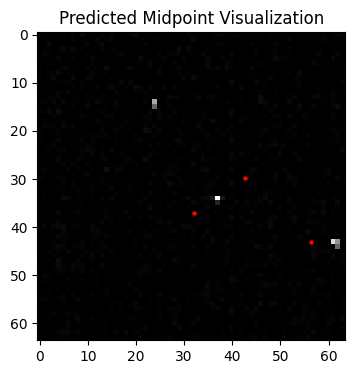

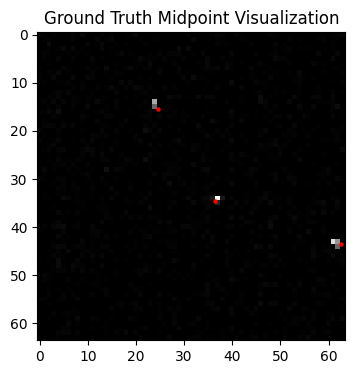

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_midpoints(image, probability_vector, midpoints, threshold=0.8):
    """
    Visualizes midpoints on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with midpoints.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    midpoints_np = midpoints#.numpy() if hasattr(midpoints, 'numpy') else midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Predicted Midpoint Visualization")

    # Plot midpoints based on probability threshold
    for i, (y,x) in enumerate(midpoints_np):
        prob = prob_vector_np[i]
        if prob > threshold:
            plt.scatter(y,x, color='red', s=5)
            # if i == 0:  # Add label only once to avoid repetition in the legend
            #     plt.legend()

    plt.show()
    
    

# t = np.random.randint(0,500)
t=90
visualize_midpoints(tf.convert_to_tensor(inputs[t]), probabilities[t].numpy().squeeze(), tf.convert_to_tensor(output[1][t,0,:,:])*[64,64]) ##myprediction   

def visualize_midpoints2(image, probability_vector, midpoints, threshold=0.8):
    """
    Visualizes midpoints on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with midpoints.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    midpoints_np = midpoints#.numpy() if hasattr(midpoints, 'numpy') else midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Ground Truth Midpoint Visualization")

    # Plot midpoints based on probability threshold
    for i, (y,x) in enumerate(midpoints_np):
        prob = prob_vector_np[i]
        if prob > threshold:
            plt.scatter(y, x, color='red', s=5)
            # if i == 0:  # Add label only once to avoid repetition in the legend
            #     plt.legend()

    plt.show()     
visualize_midpoints2(tf.convert_to_tensor(inputs[t]), probabilities[t].numpy().squeeze(), tf.convert_to_tensor(center_coordinates_np[t,0,:,:])*[64,64]) ##ground truth          




In [67]:
output[1][3],targets['x_midpoints_reshape'][3]

(array([[[ 0.30785942,  0.300475  ],
         [ 0.88270366,  0.944664  ],
         [ 0.72090876,  0.900944  ],
         [ 0.22255872,  1.061612  ],
         [ 0.6351291 ,  0.42194417],
         [ 0.16044213,  0.1669038 ],
         [ 0.21641304, -0.00662695],
         [ 0.05234019, -0.20438436],
         [-0.15603614, -0.14523216],
         [-0.02863789, -0.02402892],
         [-0.03338094, -0.03187143],
         [ 0.00226484,  0.02124727]]], dtype=float32),
 <tf.Tensor: shape=(1, 12, 2), dtype=float64, numpy=
 array([[[ 0.2109375,  0.8359375],
         [ 0.3359375,  0.8203125],
         [ 0.5078125,  0.5234375],
         [ 0.1171875,  0.9453125],
         [ 0.2734375,  0.0703125],
         [ 0.5234375,  0.2734375],
         [-0.015625 , -0.015625 ],
         [-0.015625 , -0.015625 ],
         [-0.015625 , -0.015625 ],
         [-0.015625 , -0.015625 ],
         [-0.015625 , -0.015625 ],
         [-0.015625 , -0.015625 ]]])>)

In [117]:
import numpy as np

def evaluate_model(predictions, ground_truths, probability_threshold=0.9, midpoint_diff_threshold=0.05):
    pred_probabilities = predictions[0]
    pred_midpoints = predictions[1]
    gt_probabilities = ground_truths[0]
    gt_midpoints = ground_truths[1]
    
    # Valid predictions are those above the probability threshold
    valid_predictions = pred_probabilities > probability_threshold
    no_predictions = pred_probabilities <= probability_threshold

    # Calculate differences for midpoint evaluations
    midpoint_diff = np.abs(pred_midpoints - gt_midpoints)
    is_accurate_prediction = np.all(midpoint_diff <= midpoint_diff_threshold, axis=1)
    
    # True Positives: Valid predictions close enough to the ground truth
    TP = np.sum(np.logical_and(valid_predictions, is_accurate_prediction))
    
    # False Positives: Valid predictions not close enough to the ground truth
    FP = np.sum(np.logical_and(valid_predictions, ~is_accurate_prediction))
    
    # True Negatives: No predictions where no objects are actually present
    TN = np.sum(np.logical_and(no_predictions, gt_probabilities <= probability_threshold))
    
    # False Negatives: No predictions where objects are actually present
    FN = np.sum(np.logical_and(no_predictions, gt_probabilities > probability_threshold))
    
    # Metrics calculation
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    MAE = np.mean(midpoint_diff)
    MSE = np.mean(np.square(midpoint_diff))
    
    return precision, recall, F1_score, MAE, MSE

# Usage 
predictions = [output[0][0:800], output[1][0:800]]
ground_truths = [targets['x_prob_reshape'][0:800], targets['x_midpoints_reshape'][0:800]]
precision, recall, F1_score, MAE, MSE = evaluate_model(predictions, ground_truths)

print(f"Precision: {precision}, Recall: {recall}, F1 Score: {F1_score}, MAE: {MAE}, MSE: {MSE}")


Precision: 0.5649, Recall: 1.0, F1 Score: 0.7219630647325708, MAE: 0.043563832990126686, MSE: 0.0036988505590793085
